In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModel

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The device is: {device}")

The device is: cuda


In [6]:
df = pd.read_json("/content/Sarcasm_Headlines_Dataset.json", lines=True)

In [7]:
df = df.dropna()
df = df.drop_duplicates()

In [8]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [9]:
df = df.drop(columns='article_link')

In [10]:
df.shape

(26708, 2)

In [11]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [12]:
X = np.array(df['headline'])
y= np.array(df['is_sarcastic'])

In [13]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

In [14]:
assert df.shape[0] == (X_train.shape[0] + X_test.shape[0] + X_val.shape[0])

In [15]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [16]:
class dataset(Dataset):
  def __init__(self, X, y):
    self.X = [tokenizer(x, max_length=100, truncation=True, padding="max_length", return_tensors='pt').to(device) for x in X]
    self.y = torch.tensor(y, dtype=torch.float32).to(device)
  def __len__(self):
    return len(self.X)
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [17]:
train_set = dataset(X_train, y_train)
test_set = dataset(X_test, y_test)
val_set = dataset(X_val, y_val)

In [18]:
batch_size = 32
epochs = 10

In [19]:
g = torch.Generator().manual_seed(42)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, generator=g)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, generator=g)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, generator=g)

In [20]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [21]:
bert_model.pooler.dense.out_features

768

In [22]:
class MyModel(nn.Module):
  def __init__(self, bert):
    super().__init__()

    self.bert = bert
    self.classifier = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(self.bert.pooler.dense.out_features, 384),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(384, 1),
        nn.Sigmoid()
    )
  def forward(self, input_ids, attention_mask):
    x = self.bert(input_ids, attention_mask, return_dict=False)[0][:,0]
    x = self.classifier(x)
    return x

In [23]:
for params in bert_model.parameters():
  params.requires_grad = False

In [24]:
model = MyModel(bert_model).to(device)

In [25]:
model

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [26]:
loss_fn = nn.BCELoss()
optimizer = Adam(model.classifier.parameters())

In [27]:
total_loss_train = []
total_loss_val = []
total_acc_train = []
total_acc_val = []

In [28]:
for epoch in range(epochs):
  total_acc_train_epoch = 0
  total_acc_val_epoch = 0
  total_loss_train_epoch = 0
  total_loss_val_epoch = 0

  for index, batch in enumerate(train_loader):
    inputs, labels = batch
    inputs.to(device)
    labels.to(device)

    optimizer.zero_grad()

    prediction = model(inputs['input_ids'].squeeze(1), inputs['attention_mask'].squeeze(1)).squeeze(1)

    batch_loss = loss_fn(prediction, labels)
    total_loss_train_epoch += batch_loss.item()

    acc = (prediction.round() == labels).sum().item()
    total_acc_train_epoch += acc

    batch_loss.backward()
    optimizer.step()

  with torch.no_grad():
    for index, batch in enumerate(val_loader):
      inputs, labels = batch
      inputs.to(device)
      labels.to(device)

      optimizer.zero_grad()

      prediction = model(inputs['input_ids'].squeeze(1), inputs['attention_mask'].squeeze(1)).squeeze(1)
      batch_loss = loss_fn(prediction, labels)
      total_loss_val_epoch += batch_loss.item()

      acc = (prediction.round() == labels).sum().item()
      total_acc_val_epoch += acc

  total_loss_train.append(round(total_loss_train_epoch/len(train_loader), 4))
  total_loss_val.append(round(total_loss_val_epoch/len(val_loader), 4))
  total_acc_train.append(round((total_acc_train_epoch/train_set.__len__())*100, 4))
  total_acc_val.append(round((total_acc_val_epoch/val_set.__len__())*100, 4))

  print(f"""
        Epoch: {epoch+1}
        Train Loss: {total_loss_train[-1]}
        Val Loss: {total_loss_val[-1]}
        Train Accuracy: {total_acc_train[-1]}
        Val Accuracy: {total_acc_val[-1]}
    """)


        Epoch: 1
        Train Loss: 0.39
        Val Loss: 0.3571
        Train Accuracy: 82.605
        Val Accuracy: 83.5288
    

        Epoch: 2
        Train Loss: 0.3407
        Val Loss: 0.3836
        Train Accuracy: 84.8141
        Val Accuracy: 82.1562
    

        Epoch: 3
        Train Loss: 0.322
        Val Loss: 0.3268
        Train Accuracy: 85.686
        Val Accuracy: 85.5004
    

        Epoch: 4
        Train Loss: 0.3088
        Val Loss: 0.3205
        Train Accuracy: 86.2102
        Val Accuracy: 85.9246
    

        Epoch: 5
        Train Loss: 0.2941
        Val Loss: 0.3346
        Train Accuracy: 86.9591
        Val Accuracy: 84.8515
    

        Epoch: 6
        Train Loss: 0.2829
        Val Loss: 0.3206
        Train Accuracy: 87.7561
        Val Accuracy: 86.1742
    

        Epoch: 7
        Train Loss: 0.2753
        Val Loss: 0.3169
        Train Accuracy: 87.9754
        Val Accuracy: 86.4487
    

        Epoch: 8
        Train Loss: 0.2671
 

In [30]:
with torch.no_grad():
  total_loss_test_epoch = 0
  total_acc_test_epoch = 0
  for index, batch in enumerate(test_loader):
    inputs, labels = batch
    inputs.to(device)
    labels.to(device)

    prediction = model(inputs['input_ids'].squeeze(1), inputs['attention_mask'].squeeze(1)).squeeze(1)
    batch_loss = loss_fn(prediction, labels)
    total_loss_test_epoch += batch_loss.item()

    acc = (prediction.round() == labels).sum().item()
    total_acc_test_epoch += acc
print(f"Test Loss: {round(total_loss_test_epoch/len(test_loader), 4)}")
print(f"Test Accuracy: {round((total_acc_test_epoch/test_set.__len__())*100, 4)}")

Test Loss: 0.3101
Test Accuracy: 86.4703


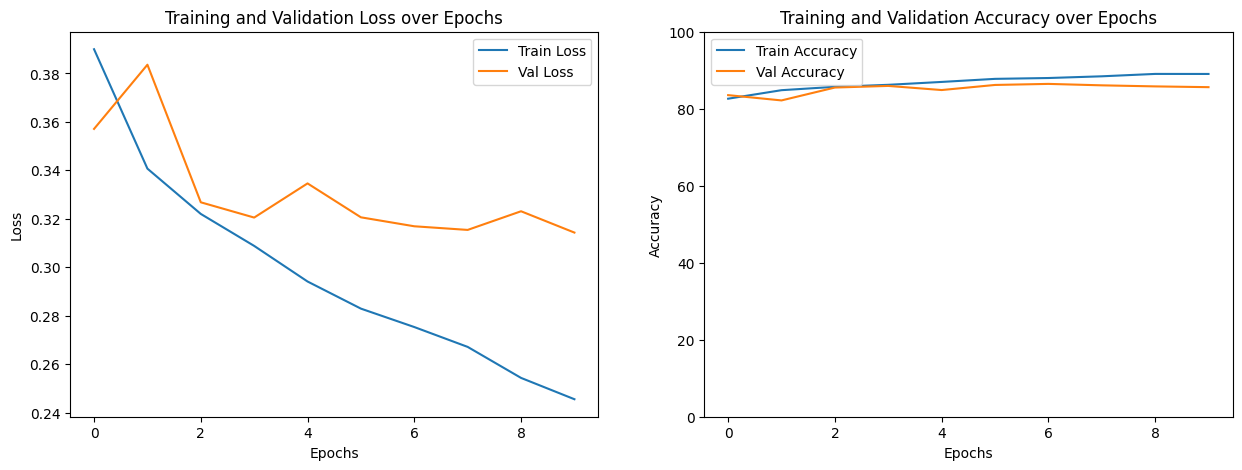

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(total_loss_train, label='Train Loss')
axs[0].plot(total_loss_val, label='Val Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train, label='Train Accuracy')
axs[1].plot(total_acc_val, label='Val Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,100])
axs[1].legend();